<a href="https://colab.research.google.com/github/srirambtechit/msc-project/blob/main/Project_Umpire_Pose_Classification_Model2_Detectron2_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cricket HighLight Video Generation by detecting Umpire gestures and poses (dataset of RGB colored without agumented noise)

### Steps followed

In notebook, we will walk through the steps required to train Detectron2 on  custom umpire dataset.

To train our detector we take the following steps:

* Install Detectron2 dependencies
* Current colab environment details
* Download custom Detectron2 object detection data
* Visualize Detectron2 training data
* Write our Detectron2 Training configuration
* Run Detectron2 training
* Evaluate Detectron2 performance
* Run Detectron2 inference on test images


# Install Detectron2 Dependencies

In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8MB 26kB/s 
     |████████████████████████████████| 6.6MB 33.1MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
     |████████████████████████████████| 276kB 7.7MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=4725271258d2e17a97bfb06f31a9468f6638626c9b582e2154510ad66ee26672
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip

In [ ]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 4.3MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201122-cp36-none-any.whl size=44456 sha256=ddc7c809202146461f9f4cc68dcb0ec89b2deefb88fe7efa2290f3edba5ccd59
  Stored in directory: /root/.cache/pip/wheels/33/7b/ec/59dffd0a0aa995739aad60ac97e70252247e9d17eae69c1cee
Successfully built fvcore


In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

# Current colab environment details

In [ ]:
# Detectron2 environment details
!python3 -m detectron2.utils.collect_env

Failed to load OpenCL runtime
------------------------  ---------------------------------------------------------------
sys.platform              linux
Python                    3.6.9 (default, Oct  8 2020, 12:12:24) [GCC 8.4.0]
numpy                     1.18.5
detectron2                0.1.3 @/usr/local/lib/python3.6/dist-packages/detectron2
detectron2 compiler       GCC 7.3
detectron2 CUDA compiler  10.1
detectron2 arch flags     sm_35, sm_37, sm_50, sm_52, sm_60, sm_61, sm_70, sm_75
DETECTRON2_ENV_MODULE     <not set>
PyTorch                   1.5.0+cu101 @/usr/local/lib/python3.6/dist-packages/torch
PyTorch debug build       False
CUDA available            True
GPU 0                     Tesla T4
CUDA_HOME                 /usr/local/cuda
NVCC                      Cuda compilation tools, release 10.1, V10.1.243
Pillow                    7.0.0
torchvision               0.6.0+cu101 @/usr/local/lib/python3.6/dist-packages/torchvision
torchvision arch flags    sm_35, sm_50, sm_60, sm_70,

In [ ]:
# Current allocated GPU configuration
!nvidia-smi

Sat Nov 28 19:49:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download custom Detectron2 object detection data

In [ ]:
!curl -L "https://app.roboflow.com/ds/Fh0fs4fFrI?key=mCZvNW8GQP" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0   1390      0 --:--:-- --:--:-- --:--:--  1388
100 20.0M  100 20.0M    0     0  17.6M      0  0:00:01  0:00:01 --:--:-- 17.6M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/No Ball10_jpg.rf.a08327f9341feb3787f556c977ac18ed.jpg  
 extracting: test/No Ball2_jpg.rf.b7c963e26b08039e155c3c2db6c0fb4a.jpg  
 extracting: test/Out16_jpg.rf.057ee6375439ab6782f87376197f27ac.jpg  
 extracting: test/Six3_jpg.rf.354995924edbe9d2da6e2a7253be21b8.jpg  
 extracting: test/Wide11_jpg.rf.a57553a2129a9a6775e5acea3451747d.jpg  
 extracting: test/Wide9_jpg.rf.4d7c0df283267c3e64e8916586a9a498.jpg  
 extracting: test/_annotations.coco.json  
 extracting: test/no_action_13_jpg.rf.c8267ebf32baef03b942579ab442467d.jpg  
 extracting: test/no_action_15_jpg.rf.416dd21c8b1ffa90642

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")


WARNING [11/30 09:08:08 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/30 09:08:08 d2.data.datasets.coco]: Loaded 930 images in COCO format from /content/train/_annotations.coco.json


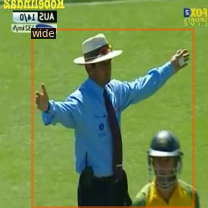

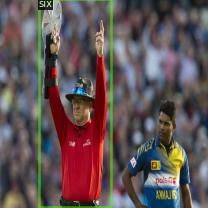

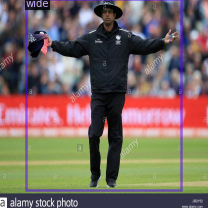

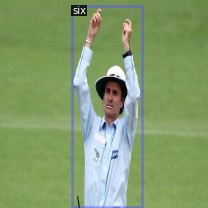

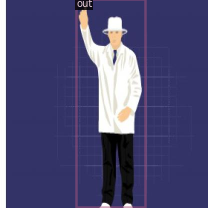

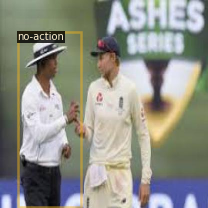

In [ ]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 6):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Train Custom Detectron2 Detector

In [ ]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
# from detectron2.tools.train_net import Trainer
# from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001

cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/28 19:52:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:18, 22.8MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (28, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (28,) in the model! You might want to double check if this is expected.


[11/28 19:52:35 d2.engine.train_loop]: Starting training from iteration 0
[11/28 19:53:14 d2.utils.events]:  eta: 0:49:08  iter: 19  total_loss: 2.775  loss_cls: 1.875  loss_box_reg: 0.869  loss_rpn_cls: 0.007  loss_rpn_loc: 0.004  time: 1.9493  data_time: 0.0254  lr: 0.000020  max_mem: 7217M
[11/28 19:53:54 d2.utils.events]:  eta: 0:49:05  iter: 39  total_loss: 2.403  loss_cls: 1.533  loss_box_reg: 0.868  loss_rpn_cls: 0.004  loss_rpn_loc: 0.003  time: 1.9911  data_time: 0.0143  lr: 0.000040  max_mem: 7217M
[11/28 19:54:33 d2.utils.events]:  eta: 0:48:03  iter: 59  total_loss: 1.808  loss_cls: 0.899  loss_box_reg: 0.920  loss_rpn_cls: 0.001  loss_rpn_loc: 0.002  time: 1.9738  data_time: 0.0131  lr: 0.000060  max_mem: 7217M
[11/28 19:55:12 d2.utils.events]:  eta: 0:47:02  iter: 79  total_loss: 1.542  loss_cls: 0.680  loss_box_reg: 0.852  loss_rpn_cls: 0.001  loss_rpn_loc: 0.002  time: 1.9693  data_time: 0.0101  lr: 0.000080  max_mem: 7217M
[11/28 19:55:52 d2.utils.events]:  eta: 0:46:1

In [ ]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [11/28 20:42:41 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/28 20:42:41 d2.data.datasets.coco]: Loaded 44 images in COCO format from /content/test/_annotations.coco.json
[11/28 20:42:41 d2.data.build]: Distribution of instances among all 6 categories:
|   category    | #instances   |  category  | #instances   |  category  | #instances   |
|:-------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| umpire-sign.. | 0            | no-action  | 14           |  no-ball   | 11           |
|      out      | 6            |    six     | 8            |    wide    | 6            |
|               |              |            |              |            |              |
|     total     | 45           |            |              |            |              |
[11/28 20:42:41 d2.data.common]: Serializing 44 elements to byte tensors and concatenating them all ...
[11/28 20:42:41 d2.data.comm

OrderedDict([('bbox',
              {'AP': 85.16656165616561,
               'AP-no-action': 79.73627362736273,
               'AP-no-ball': 65.41584158415841,
               'AP-out': 89.66336633663367,
               'AP-six': 92.70049504950495,
               'AP-umpire-signals': nan,
               'AP-wide': 98.31683168316832,
               'AP50': 90.40892510303662,
               'AP75': 90.40892510303662,
               'APl': 85.16656165616561,
               'APm': nan,
               'APs': nan})])

# Inference with Detectron2 Saved Weights



In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

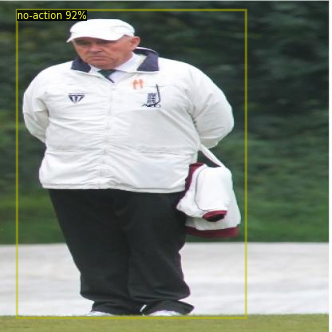

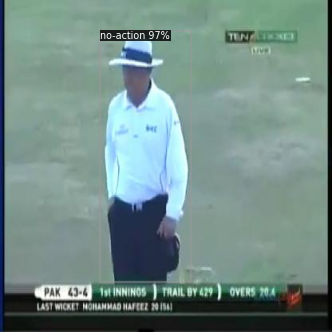

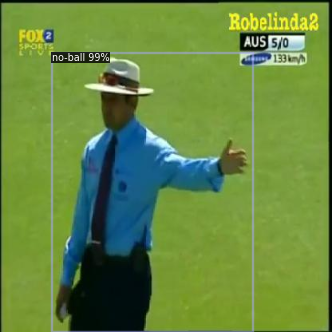

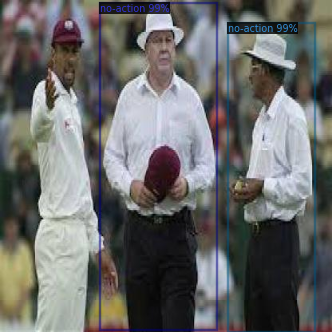

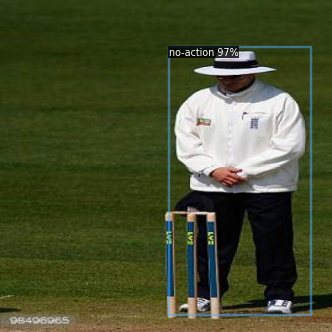

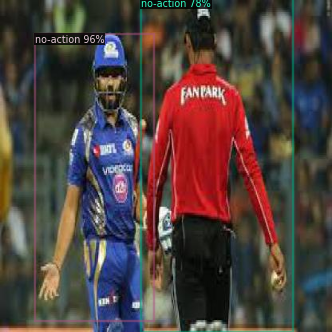

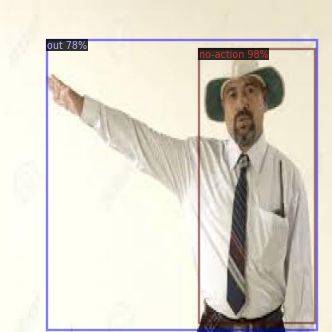

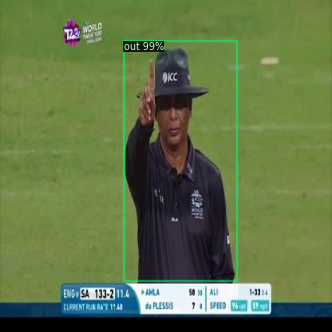

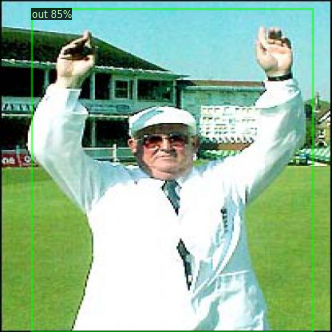

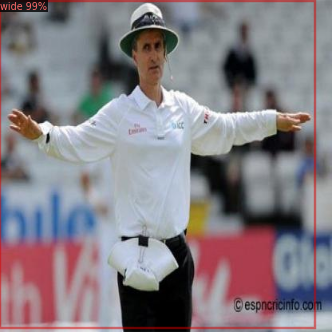

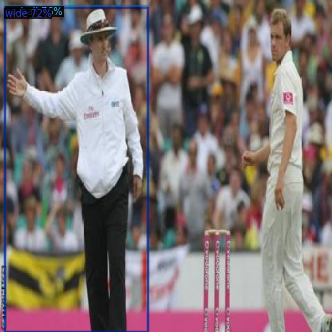

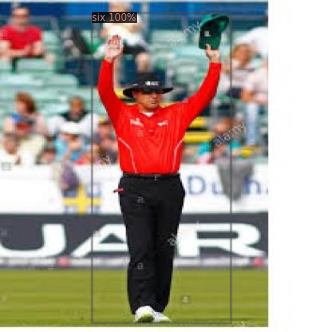

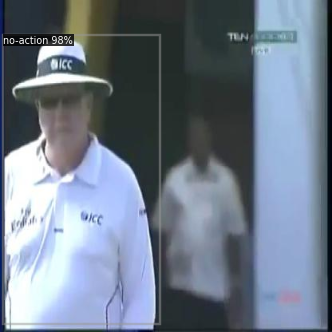

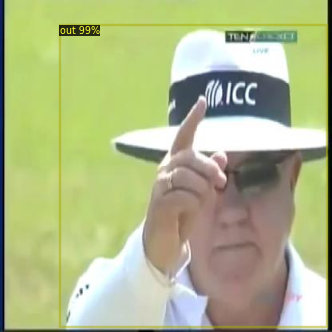

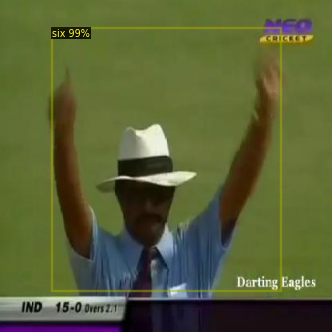

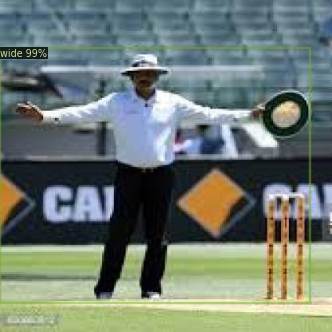

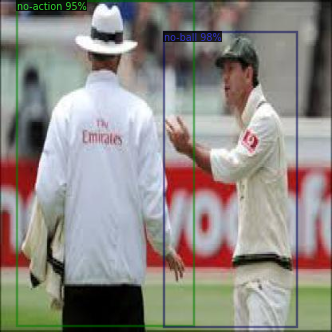

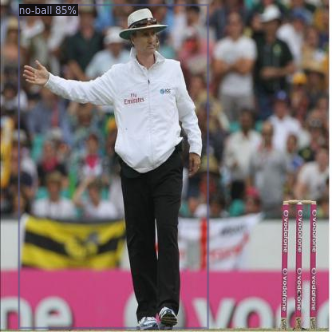

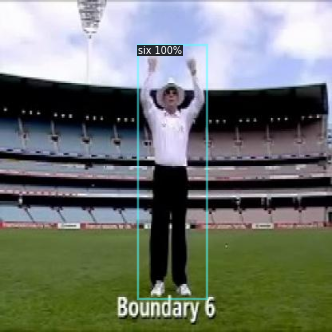

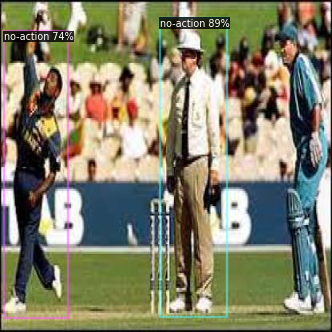

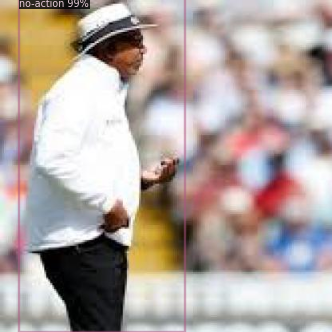

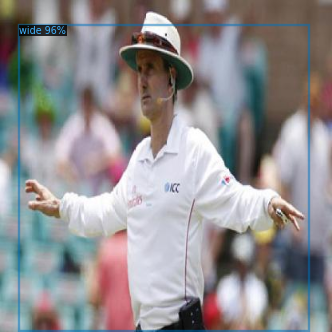

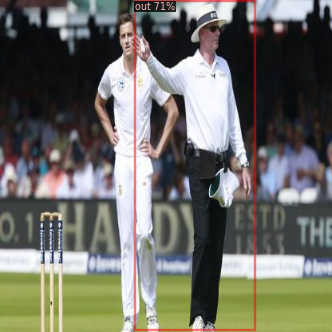

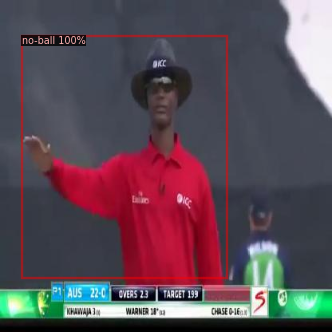

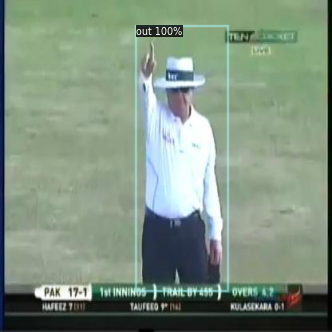

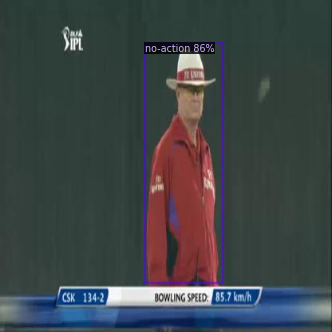

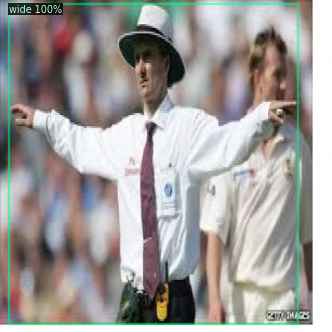

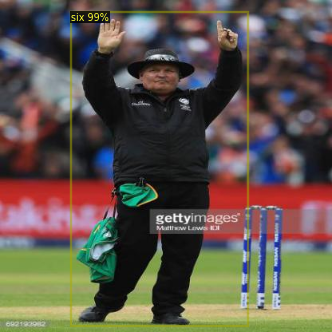

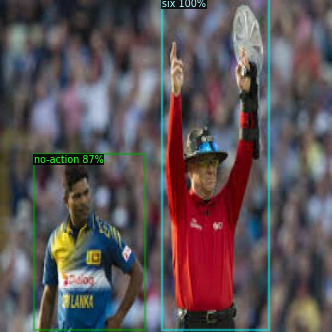

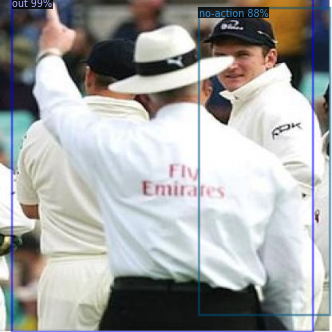

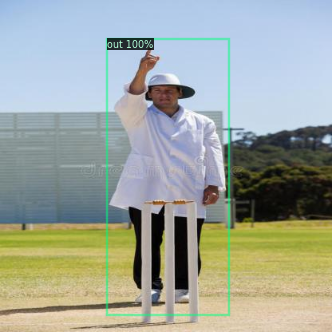

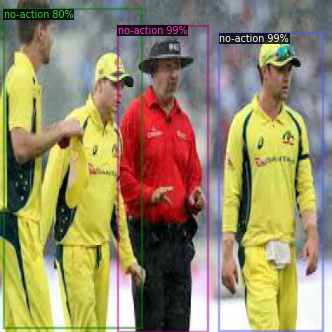

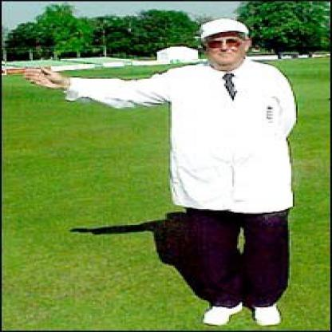

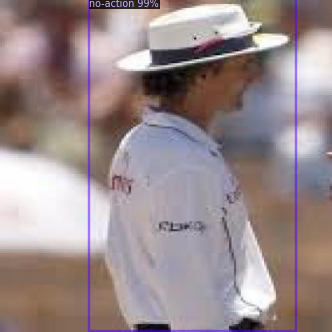

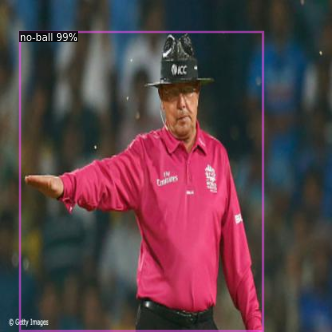

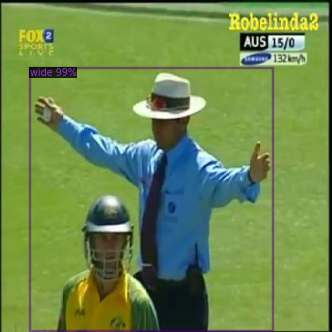

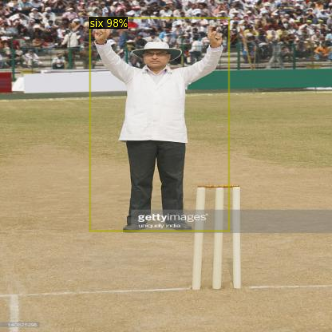

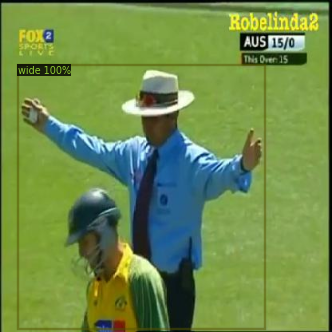

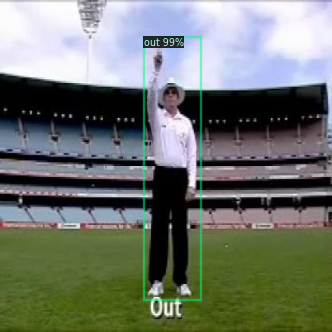

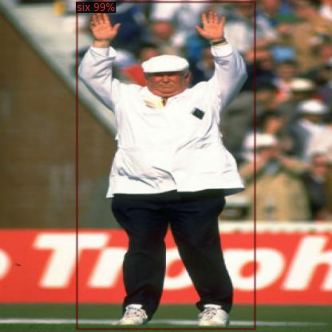

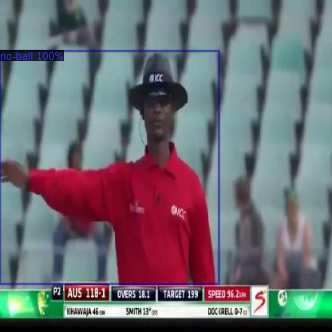

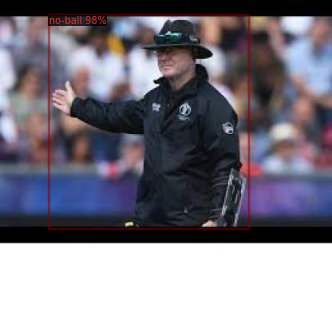

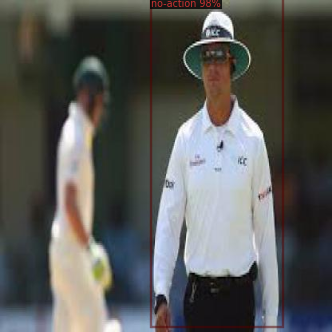

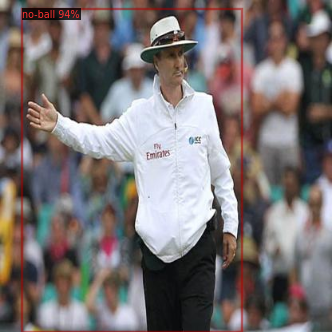

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])
